In [1]:
import numpy as np
from scipy import *
from pylab import *
import os
from scipy import interpolate,stats
from scipy.integrate import quad
import scipy.optimize as op
import sys, os
import hmf
from peak_bias_func import *
from IPython.display import Image

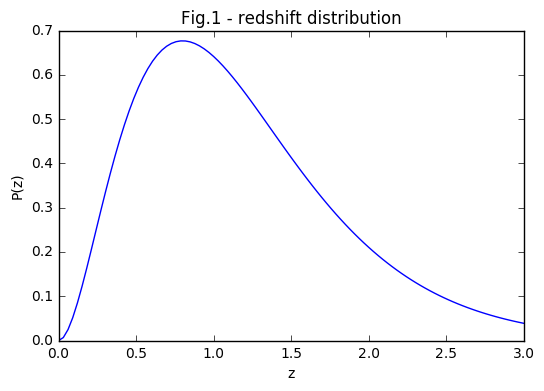

In [2]:
z_arr = linspace(0,3,100)
plot(z_arr,Pz(z_arr))
xlabel('z');ylabel('P(z)')
xlim(0,3)
title('Fig.1 - redshift distribution')
show()

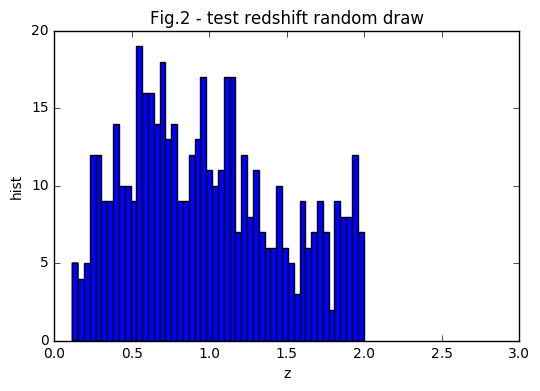

In [3]:
sample = redshift_gen(500)
hist(sample,bins=50);xlabel('z');ylabel('hist');
xlim(0,3)
title('Fig.2 - test redshift random draw')
show()

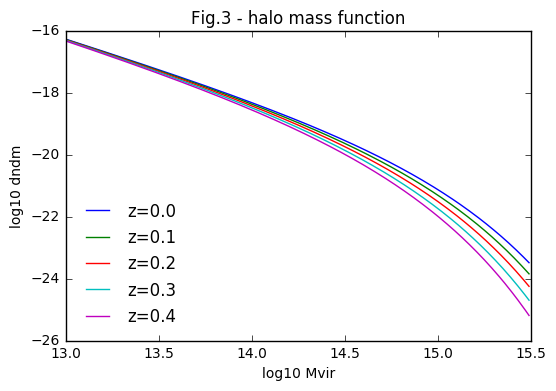

In [4]:
###### halo mass function ######
dndm_arr = array([hmf.MassFunction(z=iz, Mmin=Mmin, Mmax=Mmax, dlog10m=dlog10m).dndm for iz in z_choices])
# save('dndm_arr.npy',dndm_arr)
z_arr, M_arr = z_choices, arange(Mmin,Mmax,dlog10m)

for iii in range(5):
    plot(M_arr, log10(dndm_arr[25*iii]),label='z=%s'%(z_choices[25*iii]))
xlabel('log10 Mvir')
ylabel('log10 dndm')
title('Fig.3 - halo mass function')
legend(frameon=0,loc=0)
show()


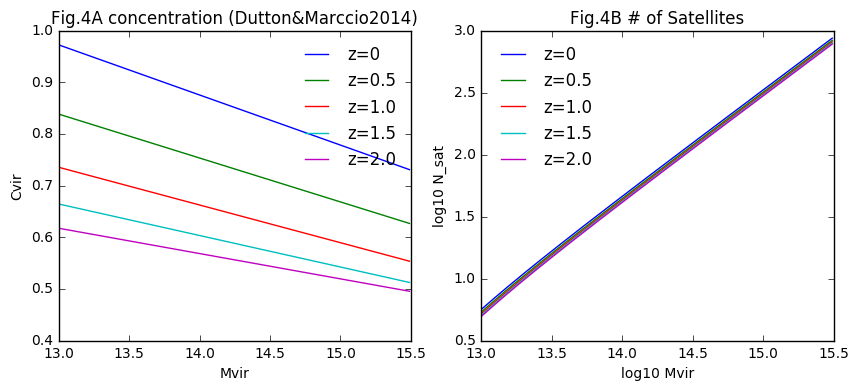

In [5]:
figure(figsize=(10,4))
subplot(121)
[plot(M_arr, log10(Cvir(M_arr, iz)), label='z=%s'%(iz)) for iz in (0,0.5,1.0,1.5,2.0)]
xlabel('Mvir')
ylabel('Cvir')
legend(frameon=0,loc=0)
title('Fig.4A concentration (Dutton&Marccio2014)')
subplot(122)
[plot(M_arr, log10(Nlens_fcn(M_arr, iz)), label='z=%s'%(iz)) for iz in (0,0.5,1.0,1.5,2.0)]
xlabel('log10 Mvir')
ylabel('log10 N_sat')
title('Fig.4B # of Satellites')
legend(frameon=0,loc=0)
show()

# One Example to Test Code

Next, I test one chain in the MC run, for specific M_vir, z, and q. The steps involved are:

(1) generate source galaxies with distribution Pz

(2) generate member galaxies with (x, y, Mvir)

(3) cut out member galaxies that fall fainter than Mlim

(4) assign sizes to the remaining member galaxies

(5) magnification bias: change the source number density at z>zlens

(6) blending: remove galaxies overlap in size

In [183]:
######################################################
########## test run with one massive lens ############
######################################################

########## parameters #########
log10M = 14.5
zlens = 0.7
q = 1.5
seed(0)
side = 10.0
rblend = 1.0/60.0 # 1 arcsec count as blended
###############################

Nlens = int(Nlens_fcn(log10M, zlens) + 0.5)

### (1) generate source galaxies with distribution Pz
area = side**2 ## arcmin^2
N_gal = Ngal_gen(ngal_mean * area)
z_source_arr = redshift_gen(N_gal)
x_source_arr = rand(N_gal) * side
y_source_arr = rand(N_gal) * side

### (2) generate member galaxies with (x, y, r, Mvir)
Mvir = 10**log10M
### number of lens members
Nlens = int(Nlens_fcn(log10M, zlens) + 0.5)
### assign a mass
Mlenses = Mlens_gen (Nlens, zlens) 
### assign x, y, according to concentration
cNFW = Cvir(log10M, zlens)
ngal_like_fcn = lambda cNFW: array([Gx_fcn(ix, cNFW) for ix in linspace(0.01, cNFW, 1001)])
ngal_like = ngal_like_fcn(cNFW)/sum(ngal_like_fcn(cNFW))    
Rvir = Rvir_fcn(Mvir, zlens) ## unit: cm
theta_vir = degrees(Rvir/Mpc/DC(zlens))*60.0 ## unit: arcmin
rlenses = theta_vir * np.random.choice(linspace(0.01, 1.0, 1001), size=Nlens, p=ngal_like)# sieze of radius in arcmin
ang_lenses = rand(Nlens)*2*pi
xlens = rlenses * sin(ang_lenses) + 5.0## in arcmin
ylens = rlenses * cos(ang_lenses) + 5.0## in arcmin

print 'number of lenses:', Nlens
print 'Rvir: %.3f Mpc, %.3f arcmin' % (Rvir/Mpc, theta_vir)

### (3) cut out member galaxies that fall fainter than Mlim
Nlim = Nlim_fcn (Nlens, zlens)

idx_lim = argsort(Mlenses)[::-1][:Nlim]
xlens = xlens[idx_lim]
ylens = ylens[idx_lim]
Mlenses = Mlenses[idx_lim]
print 'Remove %i galaxies from %i lenses that are fainter than M_lim.'%(Nlens-Nlim, Nlens)


number of lenses: 118
Rvir: 1.079 Mpc, 1.480 arcmin
Remove 63 galaxies from 118 lenses that are fainter than M_lim.


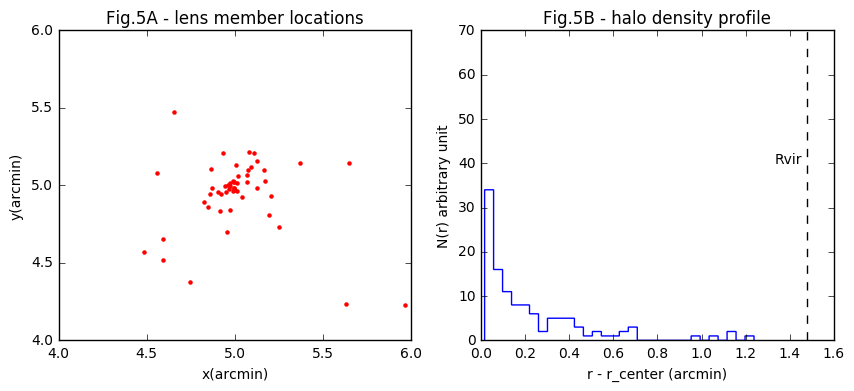

In [184]:
figure(figsize=(10,4))
subplot(121)
scatter(xlens, ylens, c='r', s=5, edgecolor='r')
xlabel('x(arcmin)')
ylabel('y(arcmin)')
xlim(4,6)
ylim(4,6)
title('Fig.5A - lens member locations')
#text(-2,2,'z=%.2f, Mvir=%.1f, N=%i'%(z_lens, M_lens, N_lens))
subplot(122)
hist(rlenses, bins=30,histtype='step')
plot([theta_vir,theta_vir],[0,70],'k--')
xlabel('r - r_center (arcmin)')
ylabel('N(r) arbitrary unit')
text(theta_vir*0.9,40,'Rvir')
title('Fig.5B - halo density profile')
show()

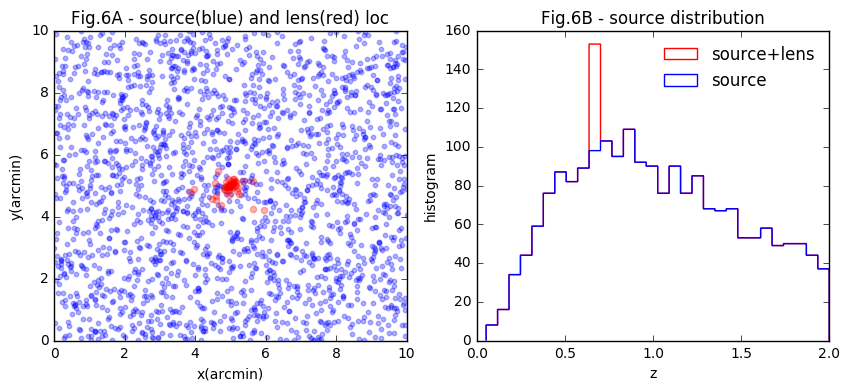

In [185]:
figure(figsize=(10,4))
subplot(121)
scatter(x_source_arr, y_source_arr, s=10, edgecolor='b',c='b',alpha=0.3)#,facecolors='none')
scatter(xlens, ylens, s=20, edgecolor='r',c='r',alpha=0.3)#,facecolors='none')
xlabel('x(arcmin)')
ylabel('y(arcmin)')
title('Fig.6A - source(blue) and lens(red) loc')
xlim(0,side)
ylim(0,side)
subplot(122)
#hist(concatenate([z_source_arr, ones(Nlens)*zlens]), bins=30, color='r',histtype='step', label='source+lens')
hist(concatenate([z_source_arr, ones(Nlim)*zlens]), bins=30, color='r',histtype='step', label='source+lens')
hist(z_source_arr, bins=30, histtype='step',color='b', label='source')
legend(frameon=0,loc=0)
xlabel('z')
ylabel('histogram')
title('Fig.6B - source distribution')
show()

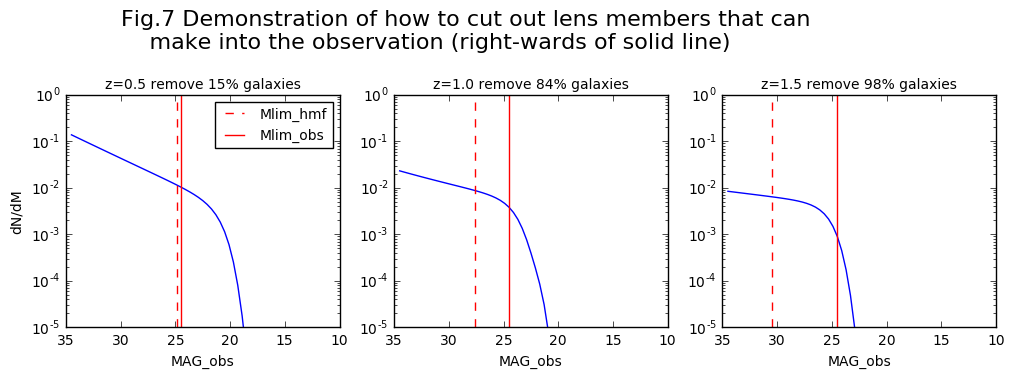

In [186]:
aMlimOBS=24.5; i=Iband
aMrest_arr = linspace(-25,-15,101)
f=figure(figsize=(12,3))
iii=0
for zz in (0.5, 1.0, 1.5):#arange(0.5,3.5, 0.5):
    iii+=1
    Mlim_hmf = LF(aMlimOBS, zz, return_Mlim_hmf=1)
    ax=f.add_subplot(1,3,iii)
    amtemp=linspace(aMlimOBS+10, aMlimOBS-10,51)
    LF_rest = array([LF(iam, zz) for iam in amtemp])
    ax.plot(amtemp, LF_rest)
    ax.set_yscale('log')
    ax.set_ylim(1e-5,1)
    ax.set_xlabel('MAG_obs')
    ax.invert_xaxis()
    ax.set_title('z=%s remove %i%% galaxies'%(zz, 100-Nlim_fcn (100, zz)),fontsize=10)
    ax.plot([Mlim_hmf,Mlim_hmf],[1e-5,1],'r--',label='Mlim_hmf')
    ax.plot([aMlimOBS,aMlimOBS],[1e-5,1],'r-',label='Mlim_obs')
    if iii==1:
        ax.set_ylabel('dN/dM')
        ax.legend(fontsize=10,loc=0)
        ax.text(30, 10, '''Fig.7 Demonstration of how to cut out lens members that can
    make into the observation (right-wards of solid line)''', fontsize=16)
show()

To get galaxy size, I use the linear galaxy-halo size relation, 0.02*R_200


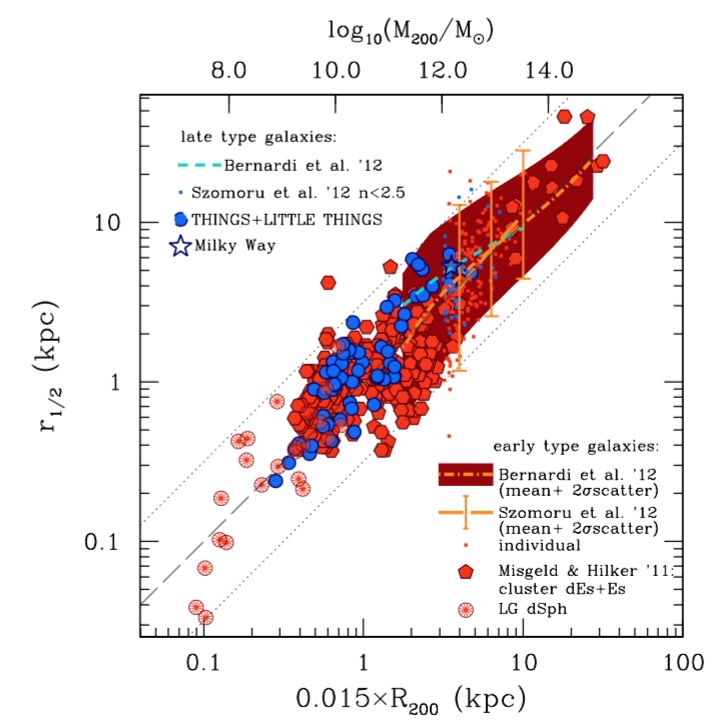

In [187]:
### (4) assign sizes to the remaining member galaxies
gal_sizes = gal_size_fcn(Mlenses, zlens) #### unit: arcmin
gal_sizes[0]=gal_size_fcn(log10M, zlens) #### this is the BCG

print "To get galaxy size, I use the linear galaxy-halo size relation, 0.02*R_200"
Image("Kravtsov2013.jpg",width=450)

In [188]:
##### (5) magnification bias: change the source number density at z>zlens
r_impact = theta_vir ### impact of magnification bias is only within virial radius
N_source_back = sum( (z_source_arr>zlens) & ( sqrt((x_source_arr-side/2)**2 + (y_source_arr-side/2)**2) < r_impact))
contributions, ikappa_real,kappa_real =  kappa_proj (log10M,  zlens, z_source_arr, x_source_arr, y_source_arr, x_lens=side/2, y_lens=side/2)
##test_kappa_real = sum(contributions*ikappa_real)/sum(contributions) ## the actual kappa
N_source_new = N_source_back * q * kappa_real
N_source_new = int(N_source_new+0.5)
## new position and redshift, but limit to higher redshift
z_source_new = np.random.choice(z_choices[z_choices>zlens], size=N_source_new, 
                                p=prob[z_choices>zlens]/sum (prob[z_choices>zlens]))
ang_new = rand(N_source_new)*2*pi
x_source_new = r_impact * rand(N_source_new) * sin(ang_new)+ side/2
y_source_new = r_impact * rand(N_source_new) * cos(ang_new)+ side/2
print '''Impact radius (arcmin): %.2f
Num. of sources at z>zlens: %i
Num. of new sourses: %i
kappa from the lens: %.2f
q=5s-2+beta: %s'''%(theta_vir, N_source_back, N_source_new, kappa_real,q)
#print sum(contributions[ikappa_real==0])/sum(contributions), test_kappa_real

Impact radius (arcmin): 1.48
Num. of sources at z>zlens: 92
Num. of new sourses: 6
kappa from the lens: 0.04
q=5s-2+beta: 1.5


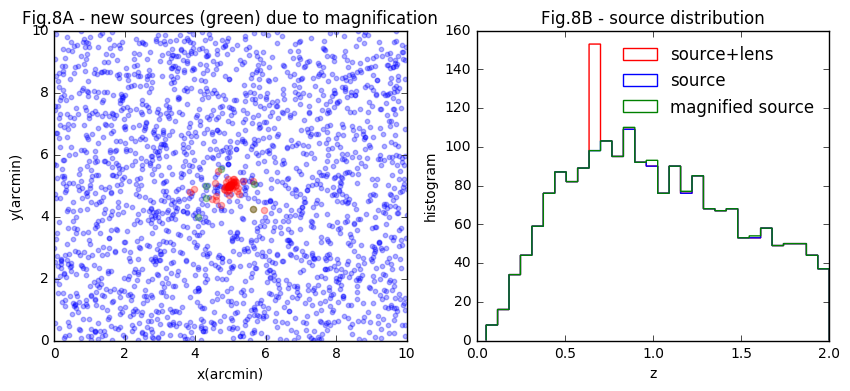

In [189]:
figure(figsize=(10,4))
subplot(121)
scatter(x_source_arr, y_source_arr, s=10, edgecolor='b',c='b',alpha=0.3)#,facecolors='none')
scatter(xlens, ylens, s=20, edgecolor='r',c='r',alpha=0.3)#,facecolors='none')
scatter(x_source_new, y_source_new, s=20, edgecolor='g',c='g',alpha=0.3)#,facecolors='none')
xlabel('x(arcmin)')
ylabel('y(arcmin)')
title('Fig.8A - new sources (green) due to magnification')
xlim(0,side)
ylim(0,side)
subplot(122)
hist(concatenate([z_source_arr, ones(Nlim)*zlens]), bins=30, color='r',histtype='step', label='source+lens')
hist(z_source_arr, bins=30, histtype='step',color='b', label='source')
hist(concatenate([z_source_arr, z_source_new]), bins=30, color='g',histtype='step', label='magnified source')
legend(frameon=0,loc=0)
xlabel('z')
ylabel('histogram')
title('Fig.8B - source distribution')
show()

In [190]:
######  (6) blending: remove galaxies overlap in size
xy = concatenate([[xlens, ylens],
                    [x_source_arr, y_source_arr],
                    [x_source_new, y_source_new]],axis=1).T
kdt = cKDTree(xy)

rblend = 0.0001/60 ### effectively not checking blends due to non-members

########## these removes all galaxies within rblend
idx_blend_tot = where(~isinf(kdt.query(xy,distance_upper_bound=rblend,k=2)[0][:,1]))[0]
########## comment out the below block for blending due to members
idx_blend_member = []
##print rblend, gal_sizes
for iii in xrange(len(xlens)):
    if gal_sizes[iii]> rblend:
        iidx = where(sqrt(sum( (xy-array([xlens[iii],ylens[iii]]))**2,axis=1)) < gal_sizes[iii])[0]
        if len (iidx) > 1:
            idx_blend_member.append(iidx)

if len(idx_blend_member)>0:
    print 'removing some members',len(idx_blend_member)
    idx_blend_member=unique(concatenate(idx_blend_member))
    idx_blend_tot = unique(concatenate([idx_blend_tot, idx_blend_member]))

###################################################    
x_blend, y_blend = xy[idx_blend_tot].T
z_blend = concatenate([ones(Nlim)*zlens, z_source_arr, z_source_new])[idx_blend_tot]
z_notblend = delete(concatenate([ones(Nlim)*zlens, z_source_arr, z_source_new]), idx_blend_tot)

removing some members 16


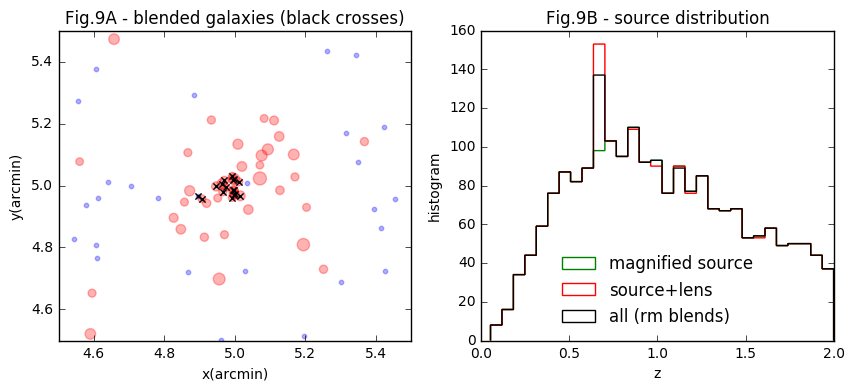

In [191]:
figure(figsize=(10,4))
subplot(121)
stemp=(gal_sizes/amin(gal_sizes))**3*30
scatter(x_source_arr, y_source_arr, s=10, edgecolor='b',c='b',alpha=0.3)
scatter(xlens, ylens, s=stemp, edgecolor='r',c='r',alpha=0.3)
scatter(x_source_new, y_source_new, s=20, edgecolor='g',c='g',alpha=0.3)
scatter(x_blend, y_blend,marker='x',facecolor='k')#s=20, facecolors='none')
xlabel('x(arcmin)')
ylabel('y(arcmin)')
title('Fig.9A - blended galaxies (black crosses)')
xlim(4.5,5.5)
ylim(4.5,5.5)

subplot(122)
hist(concatenate([z_source_arr, z_source_new]), bins=30, color='g',histtype='step', label='magnified source')
hist(concatenate([z_source_arr, ones(Nlim)*zlens]), bins=30, color='r',histtype='step', label='source+lens')
#hist(z_source_arr, bins=30, histtype='step',color='b', label='source')
hist(z_notblend, bins=30, histtype='step',color='k', label='all (rm blends)')

legend(frameon=0,loc=8)
xlabel('z')
ylabel('histogram')
title('Fig.9B - source distribution')
show()

In [192]:
###############################
###### add shape noise ########
###############################
kappa_noise_gen = lambda N: normal(0.0, 0.1, size=N) #draw N kappa_noise for sigma_kappa = 0.1 
#shear noise for HSC sigma_g^2=0.365

##x_all, y_all, z_all, kappa_all, noise_all, member, source_mb, blended

x_all = concatenate([x_source_arr, xlens, x_source_new])
y_all = concatenate([y_source_arr, ylens, y_source_new])
z_all = concatenate([z_source_arr, ones(Nlim)*zlens, z_source_new])

noise_all = kappa_noise_gen(len(x_all))

######### indexing the effects ###########
member, mag, blended = ones(shape=(3, len(x_all)))
member [len(x_source_arr):len(x_source_arr)+len(xlens)] = 0 #### 1 are the sources
if len(x_source_new)>0:
    mag [-len(x_source_new):] = 0 ### 1 is the ones not magnified
blended [idx_blend_tot] = 0 ## 1 is the ones not blended

######### calculate the kappa with various effects
r_all = hypot(x_all-side/2.0, y_all-side/2.0)
weight = exp(-0.5*r_all**2)

#print len(z_all),len(x_all),len(y_all)

kappa_all = kappa_proj (log10M,  zlens, z_all, x_all, y_all, x_lens=side/2.0, y_lens=side/2.0)[1]

kappa_sim = average(kappa_all, weights = weight*mag*member)
kappa_noisy = average(kappa_all + noise_all, weights = weight*mag*member)
noise = average(noise_all, weights = weight*mag*member)
kappa_member = average(kappa_all + noise_all, weights = weight*mag)
kappa_mag = average(kappa_all + noise_all, weights = weight*member)
kappa_blend = average(kappa_all + noise_all, weights = weight*member*mag*blended)
kappa_3eff = average(kappa_all + noise_all,weights =  weight*blended)

print '''logM=%.1f, z=%s, q=%s
Ngal_magnified\t%i
Ngal_blended\t%i
Ngal_member\t%i
kappa_sim\t%.4f
kappa_noisy\t%.4f
noise\t\t%.4f
kappa_member\t%.4f
kappa_mag\t%.4f
kappa_blend\t%.4f
kappa_3eff\t%.4f
'''%(log10M, zlens, q, len(x_source_new), len(idx_blend_tot), Nlim, kappa_sim, kappa_noisy, noise, 
     kappa_member, kappa_mag, kappa_blend, kappa_3eff)

logM=14.5, z=0.7, q=1.5
Ngal_magnified	6
Ngal_blended	17
Ngal_member	55
kappa_sim	0.0289
kappa_noisy	0.0309
noise		0.0020
kappa_member	0.0214
kappa_mag	0.0313
kappa_blend	0.0307
kappa_3eff	0.0217



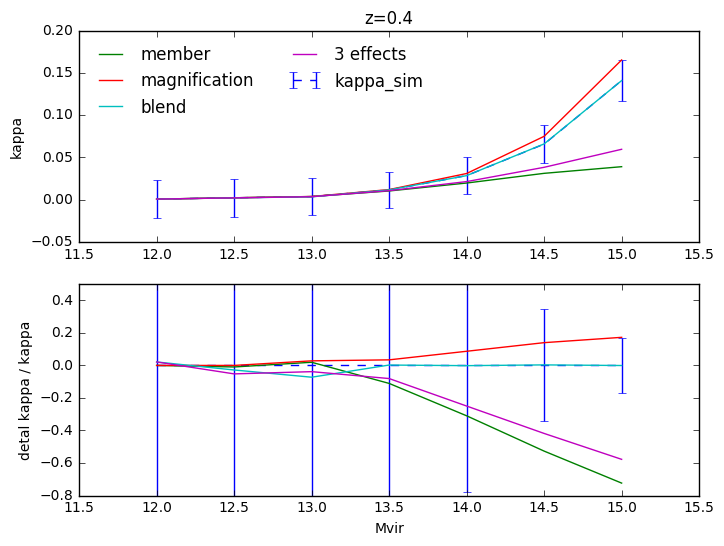

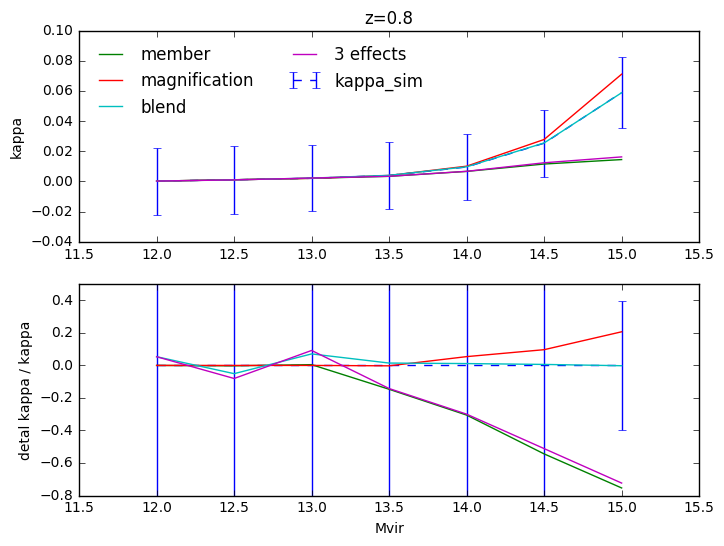

In [193]:
kappa_arr = load('kappa_arr035_theta15.npy')
ksim, knoise, noise, kmem, kmag, kblend, k3eff = [kappa_arr[:,:,:,i] for i in range(7)] ### 7 
logM_bins = arange(12.0,15.5, 0.5)
z_bins = arange(0.2, 2.2, 0.2)
for iii in (1,3):   
    f=figure(figsize=(8,6))
    ax1=f.add_subplot(211)
    ax2=f.add_subplot(212)
    imean_sim=mean(knoise[:,iii],axis=-1)
    ax1.errorbar(logM_bins, imean_sim,std(knoise[:,iii],axis=-1),label='kappa_sim',fmt='--')
    ax2.errorbar(logM_bins,zeros(len(logM_bins)),std(knoise[:,iii],axis=-1)/mean(knoise[:,iii],axis=-1),fmt='--')
    jjj=0
    for imean in [mean(karr[:,iii],axis=-1) for karr in [kmem,kmag,kblend,k3eff] ]:
        ax1.plot(logM_bins, imean, label=['member','magnification','blend','3 effects'][jjj])
        ax2.plot(logM_bins, imean/imean_sim-1)
        jjj+=1

    ax1.set_title('z=%s'%(z_bins[iii]))    
    ax1.legend(frameon=0,ncol=2,loc=0)
    ax2.set_xlabel('Mvir')
    ax1.set_ylabel('kappa')
    ax2.set_ylabel('detal kappa / kappa')
    ax2.set_ylim(-0.8,0.5)
    ax1.set_xlim(11.5, 15.5)
    ax2.set_xlim(11.5, 15.5)
    show()